# Import Important Library

In [47]:
import pandas as pd #for reaed data
import re #for text cleansing

from nltk.corpus import stopwords #for clean stopwords

#visualization
import matplotlib.pyplot as plt
import seaborn as sns 

## Read Data

In [48]:
dfText = pd.read_csv('dataset/train_preprocess.tsv', sep='\t', names=['text', 'label'])
dfText.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [49]:
dfAlay = pd.read_csv('dataset/new_kamusalay.csv', encoding='latin-1', names=['original', 'replacement'])
dfAlay

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [50]:
dfStopWord = pd.read_csv('dataset/stopwordbahasa.csv', names=['stopword'])
dfStopWord

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
...,...
753,wong
754,yaitu
755,yakin
756,yakni


# Cleansing Text

In [51]:
# remove kata alay
alay_dict_map = dict(zip(dfAlay['original'], dfAlay['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

# remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]',' ',text)

# remove stopword
stopword_list = set(stopwords.words('indonesian'))
def remove_stopword(text):
    return ' '.join([word for word in text.split(' ') if word not in stopword_list])


In [52]:
# test function
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove punc: ", remove_punctuation("aku,kamu dua"))
print("remove stopword: ", remove_stopword("agaknya kamu cantik"))

normalize_alay:  amin adik habis
remove punc:  aku kamu dua
remove stopword:  cantik


In [53]:
def preprocess(text):
    text = normalize_alay(text)
    text = remove_punctuation(text)
    text = remove_stopword(text)
    return text

In [54]:
dfText['text'] = dfText['text'].apply(preprocess)
dfText['text'] = dfText['text'].str.lower()
dfText

,text,label
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus k212 mmbri hujjah partai diw...,neutral
2,lokasi strategis jalan sumatra bandung nya n...,positive
3,betapa bahagia nya unboxing paket barang nya b...,positive
4,aduh mahasiswa sombong kasih kartu kuning ...,negative
...,...,...
10995,kecewa,positive
10996,enak masakan nya kepiting menyenangkan memilih...,positive
10997,hormati partai partai berkoalisi,neutral
10998,pagi pagi tol pasteur macet parah bikin jengkel,negative


In [55]:
dictLabel = {'positive' : 1, 'neutral' : 0, 'negative' : 2}
dfText['label'] = dfText['label'].map(dictLabel)
dfText['label']

0        1
1        0
2        1
3        1
4        2
        ..
10995    1
10996    1
10997    0
10998    2
10999    1
Name: label, Length: 11000, dtype: int64

# EDA

## Check Info Data

In [56]:
len(dfText)

11000

In [57]:
dfText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 172.0+ KB


In [58]:
dfText.isnull().sum()

text     0
label    0
dtype: int64

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenization and Change Label to Categorical

In [59]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [60]:
arrayLabel = dfText['label'].to_numpy()

In [61]:
import tensorflow as tf

labels = tf.keras.utils.to_categorical(arrayLabel, 3, dtype="float32")

In [62]:
len(labels)

11000

In [63]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dfText['text'])
sequences = tokenizer.texts_to_sequences(dfText['text'])
text = pad_sequences(sequences, maxlen=max_len)
print(text)

[[   0    0    0 ...  320  283 1818]
 [   0    0    0 ...  101 2244 2244]
 [   0    0    0 ...    1    2    2]
 ...
 [   0    0    0 ...   64   64 4347]
 [   0    0    0 ...  458   68 2538]
 [   0    0    0 ...  816    4    1]]


# Train data

In [65]:
from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop,Adam   
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text,labels, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

8250 2750 8250 2750


## LSTM

In [21]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
258/258 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.7256
Epoch 1: val_accuracy improved from -inf to 0.76655, saving model to best_model1.hdf5
258/258 [==============================] - 22s 72ms/step - loss: 0.7089 - accuracy: 0.7256 - val_loss: 0.5793 - val_accuracy: 0.7665
Epoch 2/70
  1/258 [..............................] - ETA: 20s - loss: 0.5555 - accuracy: 0.7500

KeyboardInterrupt: 

# Validation

In [78]:
import numpy as np
import keras
from sklearn.metrics import confusion_matrix

## LSTM

In [79]:
best_model = keras.models.load_model("best_model1.hdf5")

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

86/86 - 2s - loss: 0.4345 - accuracy: 0.8487 - 2s/epoch - 17ms/step
Model accuracy:  0.848727285861969


In [ ]:
predictions = best_model.predict(X_test)

86/86 [==============================] - 3s 25ms/step


In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

C:\Users\ansha\AppData\Local\Temp/ipykernel_2612/3444368053.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


<AxesSubplot:>

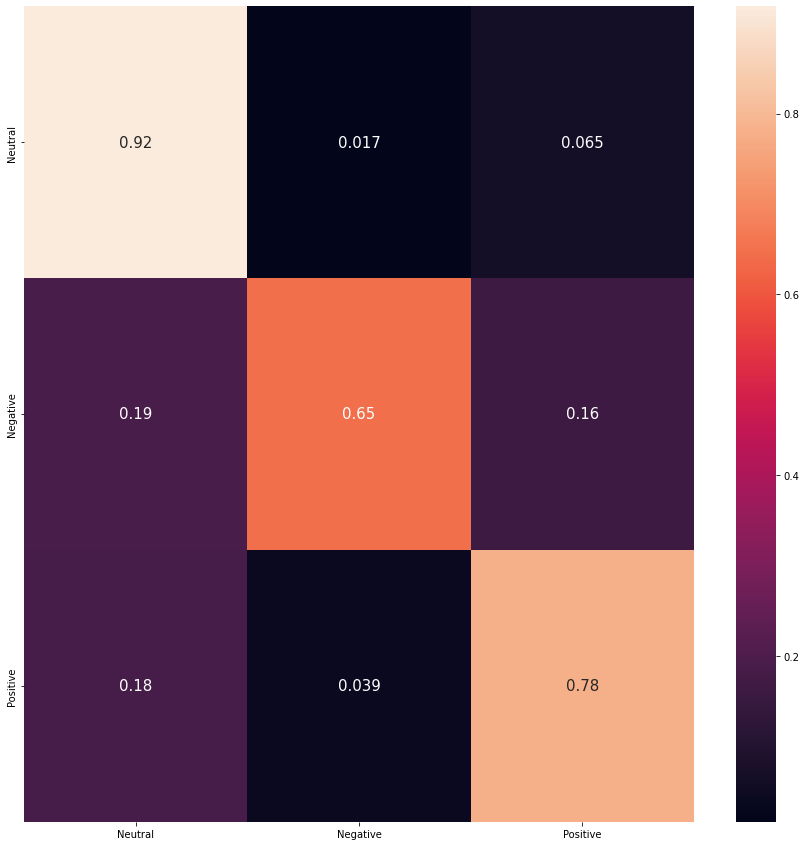

In [ ]:
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
label = ['Neutral','Positive','Negative']

In [ ]:
sequence = tokenizer.texts_to_sequences(['warung dimiliki pengusaha pabrik'])
test = pad_sequences(sequence, maxlen=max_len)
label[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 64ms/step


'Positive'